In [150]:
%matplotlib inline 
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np
import io
import sys
import datetime
import math
import scipy.io
import re

## Load in lidar data from matlab file

In [122]:
# load with scipy
mat = scipy.io.loadmat('SOS_lidar_data.mat')

# if interested in checking the variables in the mat file
for var_name in mat.keys():
    if not var_name.startswith("__"):  # Ignore special __header__, __version__, __globals__ entries
        print(f'{var_name}: {mat[var_name].shape}')

# flatten np array to 1D
mat['L4due'] = mat['L4due'].flatten()

# create dataframe and datetime index from start date for instrument
# clip to zero and interpolate missing values
start_date = pd.to_datetime('2022-10-14 00:00:00')
index = pd.date_range(start=start_date, periods=len(mat['L4due']), freq='H')
df = pd.DataFrame({'L4due': mat['L4due']}, index=index)
df.interpolate(method='linear', inplace=True)
df.clip(lower=0, inplace=True)

# select data to align with all sensors
df = df[(df.index >= '2022-11-01') & (df.index < '2023-06-01')]

L1: (4541, 1)
L11time: (4541, 1)
L1cd: (5812, 1)
L1cue: (4541, 1)
L1cuw: (2375, 1)
L1time: (5812, 1)
L2duw: (2100, 1)
L3ued: (4122, 1)
L3ueue: (5800, 1)
L3ueuw: (2375, 1)
L4: (5812, 1)
L44time: (5800, 1)
L4dd: (5812, 1)
L4due: (5800, 1)
L4duw: (2100, 1)
L4time: (2100, 1)
L4uwd: (5812, 1)
None: (1,)


/Users/clintonalden/miniconda3/envs/env1/lib/python3.12/site-packages/scipy/io/matlab/_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)
/var/folders/db/7c91t8d577n1zsyhth1xc7840000gn/T/ipykernel_2357/2218566962.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index = pd.date_range(start=start_date, periods=len(mat['L4due']), freq='H')


## Load in thermistor array data

In [182]:
path = './sos_hourly_ds.nc'

ds = xr.open_dataset(path)
ds = ds.sel(time=slice('2022-11-01', '2023-05-31'))

ds_soil = ds[[var for var in ds.data_vars if 'Tsoil' in var]]
ds = ds[[var for var in ds.data_vars if 'Tsnow' in var]]

ds_soil = ds_soil['Tsoil_0_6cm_d']


In [183]:
ds = ds[[var for var in ds.data_vars if 'Tsnow' in var]]

# Calculate the difference between consecutive time steps
diff = ds.diff(dim='time')

# Create a mask where the absolute difference is less than or equal to 1
# mask = abs(diff) <= .2

mask = ds <= 2 or ds >= -12 

# Apply the mask to the Dataset
ds = ds.where(mask)

In [184]:
summa_out = xr.open_dataset('./template_output_tilden_1hr_timestep.nc')

In [185]:
new_column_names = {'Tsnow_0_4m_d': 'uwTsnow0_4', 'Tsnow_0_5m_d': 'uwTsnow0_5', 'Tsnow_0_6m_d': 'uwTsnow0_6',
                    'Tsnow_0_7m_d': 'uwTsnow0_7', 'Tsnow_0_8m_d': 'uwTsnow0_8', 'Tsnow_0_9m_d': 'uwTsnow0_9',
                    'Tsnow_1_0m_d': 'uwTsnow1_0', 'Tsnow_1_1m_d': 'uwTsnow1_1', 'Tsnow_1_2m_d': 'uwTsnow1_2',
                    'Tsnow_1_3m_d': 'uwTsnow1_3', 'Tsnow_1_4m_d': 'uwTsnow1_4', 'Tsnow_1_5m_d': 'uwTsnow1_5'}

ds = ds.rename(new_column_names)


In [186]:
# Mask out where above top of snow
# very inefficient, but works
for i in ds.time:
    timestamp = pd.to_datetime(i.values)
    for j in ds.data_vars:
        number = float(re.findall(r'\d+\.\d+', j.replace('_', '.'))[0]) # extract depth from var name
        if number > df['L4due'].loc[timestamp]:
            mask = ds['time'] != i
            ds[j] = ds[j].where(mask, np.nan)



In [187]:
# Mask out soil temp where no snow
for i in ds_soil.time:
    timestamp = pd.to_datetime(i.values)
    if df['L4due'].loc[timestamp] < 0.1:
        mask = ds_soil['time'] != i
        ds_soil = ds_soil.where(mask, np.nan)

In [202]:
# initialize depth array
depths = np.arange(0.4, 1.6, 0.1)

# Create a list of names
var_names = [f'uwTsnow{int(i/10)}_{i%10}' for i in range(4, 16)]

# Create an empty list to store the arrays
arrays = []

# Loop over the desired range
for i in range(4, 16):
    # Create an array filled with the current value and append it to the list
    arrays.append(np.full(5088, i / 10.0))

# Convert the list of arrays into a 2D array
array = np.array(arrays)

# Extract the depths from the variable names
depths = [float(var.split('_')[1].replace('_', '.')) for var in var_names]

# Create a 2D array where each row corresponds to a variable and each column corresponds to a time point
data = np.array([ds[var].values for var in var_names])

# Create a 2D array for the y coordinates (depths)
depths = np.array([np.full_like(ds[var].values, depth) for depth, var in zip(depths, var_names)])/10

# Create a 2D array for the x coordinates (time points)
times = np.array([ds[var].coords['time'].values for var in var_names])


In [203]:
new_row = ds_soil.values  # Convert the Dataset variable to a numpy array

# Make sure the new row has the same number of columns as the array
assert new_row.shape[0] == data.shape[1]

# Add the new row to the array
# data = np.vstack((data, new_row))
data

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [204]:
# Assuming `array` is your 12x5088 numpy array
new_row = np.zeros(array.shape[1])  # Create a new row filled with zeros
# array = np.vstack((array, new_row))  # Add the new row to the array
array

array([[0.4, 0.4, 0.4, ..., 0.4, 0.4, 0.4],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.6, 0.6, 0.6, ..., 0.6, 0.6, 0.6],
       ...,
       [1.3, 1.3, 1.3, ..., 1.3, 1.3, 1.3],
       [1.4, 1.4, 1.4, ..., 1.4, 1.4, 1.4],
       [1.5, 1.5, 1.5, ..., 1.5, 1.5, 1.5]])

In [205]:
new_row = times[0, :]  # Get the first row
# times = np.vstack((times, new_row))


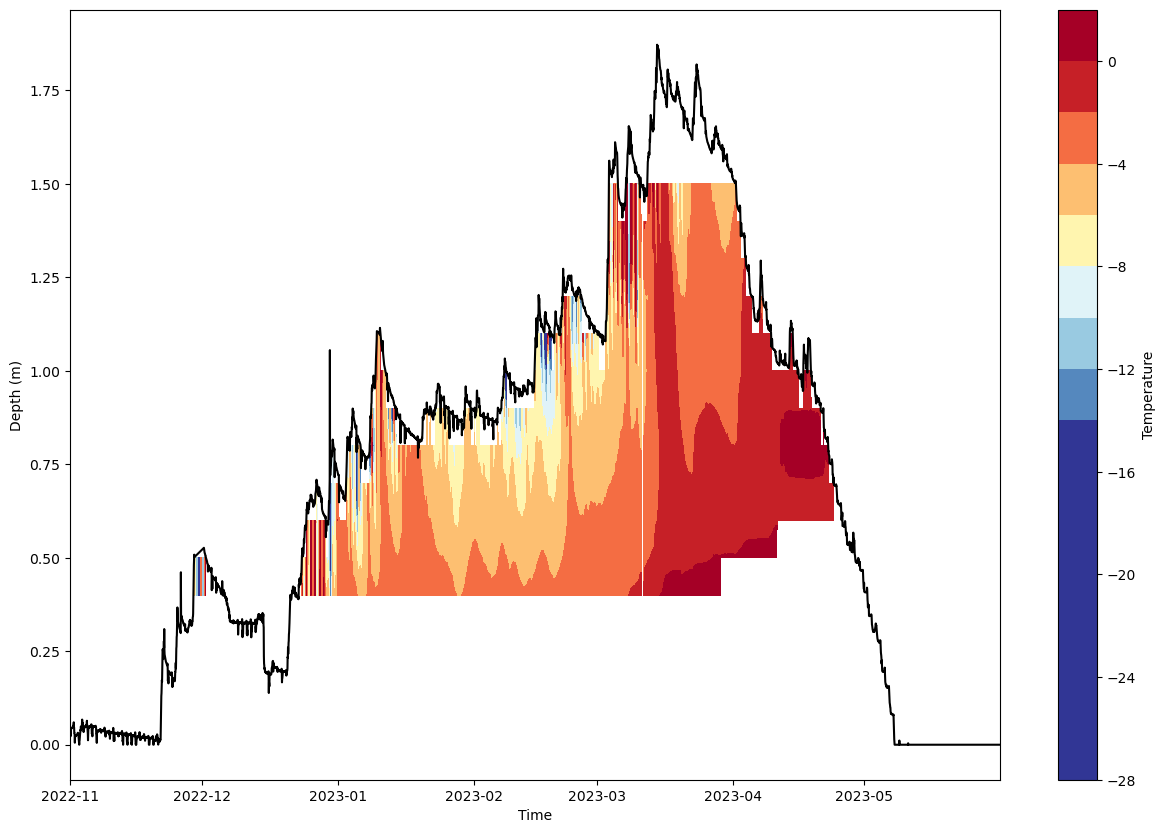

In [198]:
plt.figure(figsize=(15, 10))

# Create a filled contour plot
plt.contourf(times, array, data, vmin=-15, vmax=0, levels=15, cmap='RdYlBu_r')

# Add a colorbar
plt.colorbar(label='Temperature')

# Set the y-axis direction to reverse (so that depth increases downwards)
# plt.gca().invert_yaxis()

# Plot summa snow depth output
# plt.plot(summa_out['time'], summa_out['scalarSnowDepth'], color='black')
plt.plot(df.index, df['L4due'], color='black')

# Set the labels for the x-axis and y-axis
plt.xlabel('Time')
plt.ylabel('Depth (m)')

# plt.xlim([np.datetime64('2023-02-01'), np.datetime64('2023-03-31')])

# Show the plot
plt.show()

In [74]:
# Reshape df['L4due'] to match the shape of depths
L4due = np.repeat(df['L4due'].values[None, :], depths.shape[0], axis=0)

L4due = L4due[:,:5544]

# Create a mask where the depths are less than or equal to L4due
mask = depths <= L4due

# Apply the mask to the data
data_masked = np.where(mask, data, np.nan)

In [90]:
L4due[:,:5544].shape

# Create a 2D array for the y coordinates (depths)
depths = np.array([np.full_like(ds[var].values, depth) for depth, var in zip(depths, var_names)])/10


In [206]:
import xarray as xr

# Assuming `data` is your numpy array,
# and `dim1` and `dim2` are your other two arrays

times = times.flatten()
# array = array.flatten()
da = xr.DataArray(data, coords=[('dim1', times), ('dim2', array)])

ValueError: Variable 'dim_1': Could not convert tuple of form (dims, data[, attrs, encoding]): ('dim2', array([[0.4, 0.4, 0.4, ..., 0.4, 0.4, 0.4],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.6, 0.6, 0.6, ..., 0.6, 0.6, 0.6],
       ...,
       [1.3, 1.3, 1.3, ..., 1.3, 1.3, 1.3],
       [1.4, 1.4, 1.4, ..., 1.4, 1.4, 1.4],
       [1.5, 1.5, 1.5, ..., 1.5, 1.5, 1.5]])) to Variable.